In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
FILEPATH='data/block_2010_data/nhgis0005_csv'
relevant_cols = ['GISJOIN', 'STATEA', 'COUNTYA', 'H7X001', 'H7X002', 'H7X003', 'H7X004', 
                               'H7X005', 'H7X006', 'H7X007', 'H7X008']
race_raw = pd.read_csv(f'{FILEPATH}/nhgis0005_ds172_2010_block.csv', 
                       usecols=relevant_cols, 
                       dtype={'GISJOIN': str, 'STATEA': str, 'COUNTYA': str})
column_mapper = dict(zip(relevant_cols, ['GISJOIN', 'state_fips', 'county_fips', 'total', 'white',
                                        'black', 'american_indian_al_native', 'asian', 
                                        'hawaiian_pac_islander', 'other', 'two_plus']))
race_raw.rename(columns=column_mapper, inplace=True)
print("Race data loaded.")
race_raw.set_index('GISJOIN', inplace=True)
race_raw

Race data loaded.


state_fips county_fips  total  white  black  \
GISJOIN                                                          
G06000104001001000         06         001      0      0      0   
G06000104001001001         06         001      0      0      0   
G06000104001001002         06         001      0      0      0   
G06000104001001003         06         001      0      0      0   
G06000104001001004         06         001      0      0      0   
...                       ...         ...    ...    ...    ...   
G42013300240022033         42         133     19     18      0   
G42013300240022034         42         133     48     48      0   
G42013300240022035         42         133     16     16      0   
G42013300240022036         42         133     44     35      2   
G42013300240022037         42         133     19     19      0   

                    american_indian_al_native  asian  hawaiian_pac_islander  \
GISJOIN                                                                       
G06000104001001000                          0      0                      0   
G06000104001001001                          0      0                      0   
G06000104001001002                          0      0                      0   
G06000104001001003                          0      0                      0   
G06000104001001004                          0      0                      0   
...                                       ...    ...                    ...   
G42013300240022033                          0      0                      0   
G42013300240022034                          0      0                      0   
G42013300240022035                          0      0                      0   
G42013300240022036                          0      0                      0   
G42013300240022037                          0      0                      0   

                    other  two_plus  
GISJOIN                              
G06000104001001000      0         0  
G06000104001001001      0         0  
G06000104001001002      0         0  
G06000104001001003      0         0  
G06000104001001004      0         0  
...                   ...       ...  
G42013300240022033      0         1  
G42013300240022034      0         0  
G42013300240022035      0         0  
G42013300240022036      0         7  
G42013300240022037      0         0  

[2699631 rows x 10 columns]

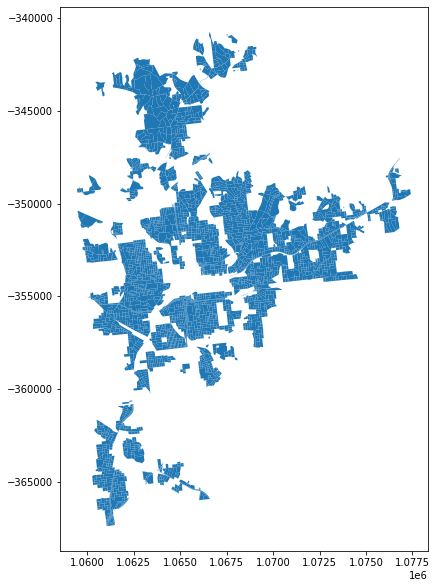

In [4]:
atlanta_blocks = gpd.read_file(
    'data/block_2010_data/nhgis0005_shape/nhgis0005_shapefile_tl2010_130_block_2010/GA_block_2010.shp').set_index('GEOID10')
atlanta_rl_cw = pd.read_csv('data/outputs/Atlanta_blocks_2010_crosswalk.csv', dtype={'block_id_2010': str}).set_index('block_id_2010')
atlanta_blocks = atlanta_blocks.join(atlanta_rl_cw, how='outer').dropna().set_index('GISJOIN')
atlanta_blocks.plot(figsize=(10,10))

In [5]:
atlanta = atlanta_blocks.join(race_raw, how='outer').dropna()

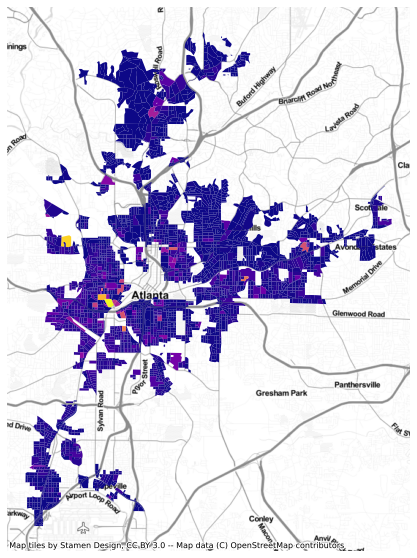

In [11]:
import contextily as ctx
def plot_map(df, column, figsize=(10,10), cmap='plasma'):
    ax = df.to_crs(epsg=3857).plot(figsize=figsize, cmap=cmap, column=column)
    ax.set_axis_off()
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

plot_map(atlanta, 'black')

In [12]:
R = atlanta.groupby('holc_id_uq').sum().filter(['total', 'white', 'black', \
    'american_indian_al_native', 'asian', 'hawaiian_pac_islander', \
    'hawaiian_pac_islander', 'other', 'two_plus'])

In [13]:
R

total  white  black  american_indian_al_native  asian  \
holc_id_uq                                                          
A0           3102   2981     22                          1     84   
A1           1311   1268     12                          2     19   
A2            410    396      1                          1      4   
A3            115    114      0                          0      1   
A4            339    239     62                          0      7   
...           ...    ...    ...                        ...    ...   
D95           190    145     27                          0     14   
D96          1265    644    417                          6    110   
D97            33      7     26                          0      0   
D98          1553    256   1039                         11      4   
D99           321    105    142                         14      5   

            hawaiian_pac_islander  hawaiian_pac_islander  other  two_plus  
holc_id_uq                                                                 
A0                              0                      0      1        13  
A1                              3                      3      4         3  
A2                              0                      0      1         7  
A3                              0                      0      0         0  
A4                              0                      0     25         6  
...                           ...                    ...    ...       ...  
D95                             0                      0      0         4  
D96                             4                      4     30        54  
D97                             0                      0      0         0  
D98                             0                      0    223        20  
D99                             0                      0     49         6  

[109 rows x 9 columns]

In [32]:
def city_entropy(R, P):
    """
    Computes entropy of a city-region (see White, 1986).

    Parameters
    ----------
    R : numpy.ndarray
        i-by-j matrix, where i=districts and j=ethnicities.
    P : numpy.array
        i-length vector of the total population in a city-region.
    
    Returns
    -------
    int
        citywide segregation entropy score.
    """
    # define key terms in algorithm
    N = sum(P)
    i, j = R.shape
    R_prop = np.nan_to_num(np.apply_along_axis(lambda column: column / P, 0, R))
    r_hat = R.sum(axis=0) / N

    
    def entropy(x):
        """compute an entropy score with region ethnicity proportion vector x."""
        with np.errstate(divide='ignore'):
            vec = np.log(x)
        vec[np.isneginf(vec)] = 0 # fix special case where 0 * ln(0) = 0
        return (-1) * sum(x*vec)
    
    # compute district-level entropy scores
    h_i = list(map(entropy, R_prop))

    # compute city-wide entropy
    H_hat = entropy(r_hat)
    H_bar = sum((P/N) * h_i)
    
    return (H_hat - H_bar) / H_hat


In [15]:
def chain_to_entropy(chainobj, blocks):
    """
    Takes element in Markov Chain and computes entropy score using the partition map.
    Parameters
    ----------
    chainobj : gerrychain.partition.partition.Partition
        Partition object that dictates which elements belong to which partitions.
    blocks : geopandas.GeoDataFrame
        Dataframe containing the map's census blocks and associated race information.
    
    Returns
    -------
    int
        entropy score using the partition data from Markov Chain element.
    """
    # use partition parts and grouping to create R and P
    R = blocks.drop(columns=['geometry']).copy()
    R['partition'] = blocks.index.map(dict(chainobj.assignment))
    R = R.groupby('partition').sum()
    R, P = R.to_numpy()[:, 1:], R.to_numpy()[:, 0]

    return city_entropy(R, P)

In [16]:
race_matrix = atlanta.filter(['total', 'white', 'black', 'american_indian_al_native', 'asian', 'hawaiian_pac_islander', 'other', 'two_plus', 'holc_id_uq', 'geometry'])
race_matrix.rename(columns={'holc_id_uq': 'partition'}, inplace=True)
race_matrix

total  white  black  american_indian_al_native  asian  \
GISJOIN                                                                     
G13008900201001016      0      0      0                          0      0   
G13008900201001017    134    130      0                          0      1   
G13008900201001018     77     69      6                          0      0   
G13008900201001019     44     42      0                          0      1   
G13008900201001020     58     56      2                          0      0   
...                   ...    ...    ...                        ...    ...   
G13012109800001038      0      0      0                          0      0   
G13012109800001039      0      0      0                          0      0   
G13012109800001040      0      0      0                          0      0   
G13012109800001041      0      0      0                          0      0   
G13012109800001042      0      0      0                          0      0   

                    hawaiian_pac_islander  other  two_plus partition  \
GISJOIN                                                                
G13008900201001016                      0      0         0        A7   
G13008900201001017                      0      0         3        A7   
G13008900201001018                      0      0         2        A7   
G13008900201001019                      0      0         1        A7   
G13008900201001020                      0      0         0        A7   
...                                   ...    ...       ...       ...   
G13012109800001038                      0      0         0       C72   
G13012109800001039                      0      0         0       C72   
G13012109800001040                      0      0         0       C72   
G13012109800001041                      0      0         0       C72   
G13012109800001042                      0      0         0       C72   

                                                             geometry  
GISJOIN                                                                
G13008900201001016  POLYGON ((1068795.295 -348363.945, 1068775.515...  
G13008900201001017  POLYGON ((1068738.944 -348302.783, 1068744.852...  
G13008900201001018  POLYGON ((1068706.259 -348247.260, 1068647.320...  
G13008900201001019  POLYGON ((1068437.777 -348296.334, 1068434.409...  
G13008900201001020  POLYGON ((1068681.548 -348808.789, 1068673.130...  
...                                                               ...  
G13012109800001038  POLYGON ((1061463.650 -367086.147, 1061446.372...  
G13012109800001039  POLYGON ((1061355.316 -367319.838, 1061357.047...  
G13012109800001040  POLYGON ((1061477.144 -367221.680, 1061455.189...  
G13012109800001041  POLYGON ((1061478.146 -367242.039, 1061454.423...  
G13012109800001042  POLYGON ((1061349.053 -367245.766, 1061305.264...  

[3525 rows x 10 columns]

In [17]:
def compute_total_pop(partition):
    global race_matrix
    R = race_matrix.drop(columns=['geometry']).copy()
    R['partition'] = race_matrix.index.map(dict(partition.assignment))
    return R.groupby('partition').sum()['total'].to_dict()

In [18]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain, proposals, updaters, constraints, accept)
from gerrychain.updaters import Tally
from gerrychain.proposals import recom, propose_chunk_flip, propose_random_flip
from gerrychain.constraints import districts_within_tolerance, no_vanishing_districts, WithinPercentRangeOfBounds
from gerrychain.accept import always_accept
from functools import partial
from tqdm.notebook import tqdm
import networkx as nx

graph = Graph.from_geodataframe(race_matrix, adjacency='queen')

(1058546.848742942,
 1078311.9602717448,
 -368688.0350447231,
 -339429.34006718843)

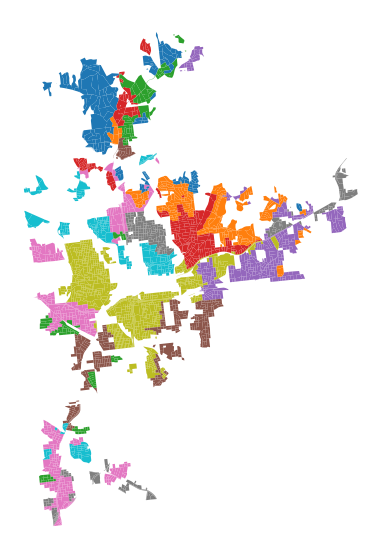

In [19]:
nx.set_node_attributes(graph, race_matrix['total'].to_dict(), name='population')
init_partition = Partition(graph, 
                    assignment=race_matrix.to_dict()['partition'],
                    updaters={'population' : Tally('population')})
init_partition.plot(figsize=(10,10))
plt.axis('off')

{'A7': 1397,
 'B14': 2931,
 'C43': 4478,
 'C41': 2775,
 'B16': 1278,
 'D110': 166,
 'D80': 2370,
 'C53': 3143,
 'C52': 5068,
 'D81': 3606,
 'C51': 2011,
 'B22': 280,
 'C54': 3144,
 'B33': 2195,
 'A6': 1117,
 'C48': 1134,
 'D105': 805,
 'D106': 104,
 'C46': 2098,
 'C44': 220,
 'B15': 600,
 'C45': 31,
 'D108': 1943,
 'C49': 2769,
 'B17': 1325,
 'C50': 224,
 'A8': 202,
 'B19': 129,
 'D101': 0,
 'B18': 466,
 'D109': 374,
 'B21': 296,
 'D107': 43,
 'C47': 1220,
 'B13': 5578,
 'C40': 2047,
 'C38': 44,
 'C39': 1381,
 'B12': 1043,
 'C75': 2339,
 'C70': 126,
 'C76': 2396,
 'B11': 482,
 'D92': 5019,
 'D93': 701,
 'D88': 10016,
 'D87': 5598,
 'C77': 13536,
 'B27': 1594,
 'C78': 3173,
 'C42': 4792,
 'D91': 5810,
 'D89': 1839,
 'D82': 10765,
 'C66': 3747,
 'B25': 1383,
 'C65': 2580,
 'D86': 192,
 'C55': 3219,
 'C56': 920,
 'D84': 1300,
 'C58': 600,
 'D85': 3086,
 'C63': 1620,
 'B26': 684,
 'C64': 1826,
 'B23': 303,
 'C62': 1647,
 'C61': 629,
 'B24': 615,
 'D83': 148,
 'C57': 67,
 'D102': 1231,
 'C6

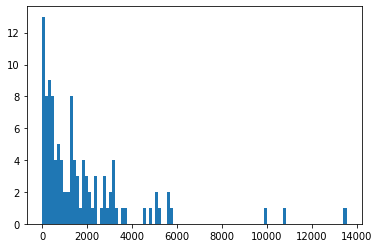

In [21]:
import seaborn as sns
plt.hist(list(init_partition['population'].values()), bins=100)
np.percentile(list(init_partition['population'].values()), [2.5, 97.5])
init_partition['population']

In [48]:
ideal_population = sum(compute_total_pop(init_partition).values()) / len(init_partition)
from gerrychain.constraints import Validator, LowerBound
mean_pop = lambda part: np.mean(list(part['population'].values()))
min_pop = lambda part: min(list(part['population'].values()))
is_valid = Validator([WithinPercentRangeOfBounds(mean_pop, 25), LowerBound(min_pop, 0)])
BURN_IN = 1000
STEP_COUNT = 100000 + BURN_IN
proposal = partial(recom, 
                    pop_col='population', 
                    pop_target=ideal_population,
                    epsilon=100,
                    node_repeats=20000000)
chain = MarkovChain(proposal=propose_chunk_flip, 
                    constraints=is_valid,
                    accept=always_accept, 
                    initial_state=init_partition, 
                    total_steps=STEP_COUNT)
print('Prereqs created, chain running...')
# burn-in of 1000
iter(chain)
print("Burn-in:")
_ = [next(chain) for i in tqdm(range(BURN_IN))]
entropies = [chain_to_entropy(next(chain), race_matrix) for i in tqdm(range(STEP_COUNT - BURN_IN))]
chain = None
np.save("results/arrays/atlanta_cf_100000.npy", entropies)

Prereqs created, chain running...
Burn-in:


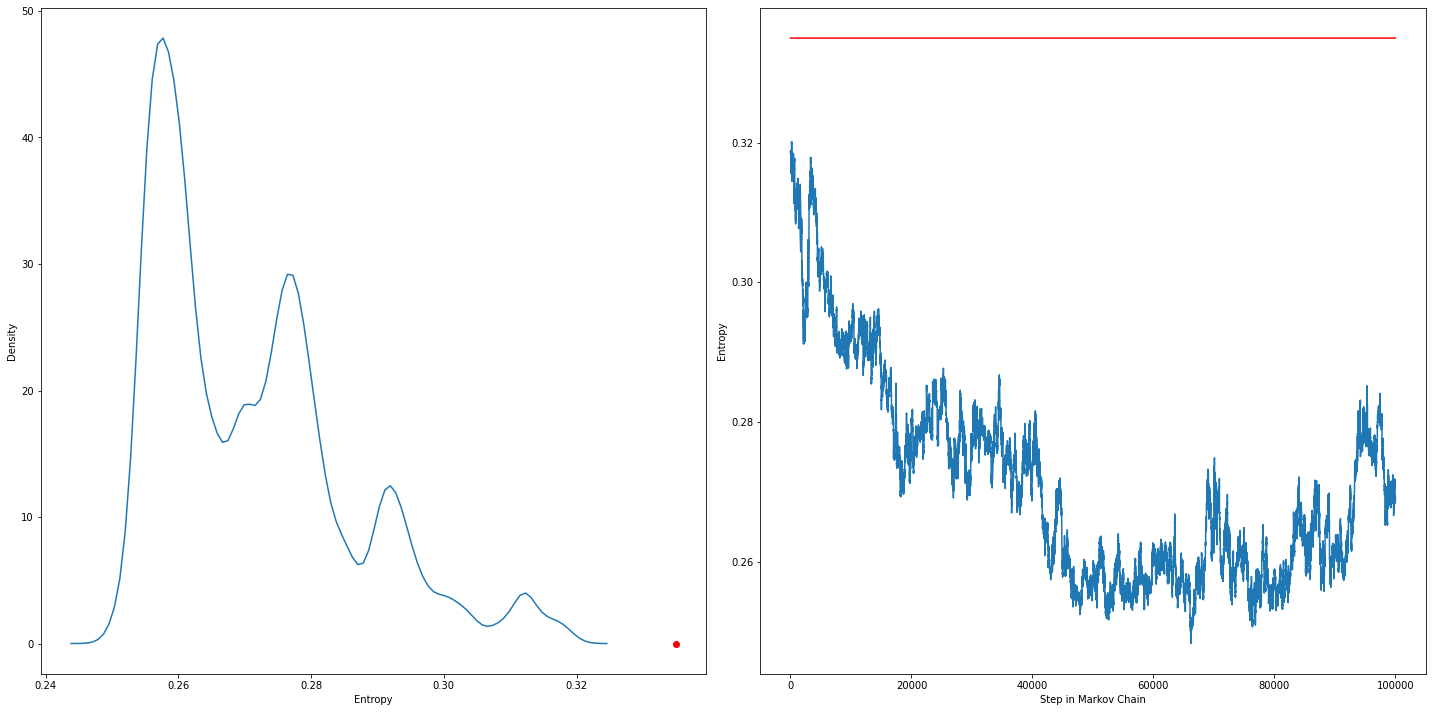

In [49]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.xlabel("Entropy")
plt.ylabel("Density")
sns.kdeplot(entropies)
plt.scatter(city_entropy(R.to_numpy()[:, 1:], R.to_numpy()[:, 0]), 0, c='r')

plt.subplot(1, 2, 2)
plt.xlabel("Step in Markov Chain")
plt.ylabel("Entropy")
plt.plot(np.arange(STEP_COUNT - 1000), entropies)
plt.plot(np.arange(STEP_COUNT - 1000), np.repeat(city_entropy(R.to_numpy()[:, 1:], R.to_numpy()[:, 0]), STEP_COUNT - 1000), c='r')

plt.tight_layout()
plt.savefig("results/plots/atlanta_cf_100000.png")

In [31]:
R_matrix = R.to_numpy()[:, 1:]
P_vector = R.to_numpy()[:, 0]

np.apply_along_axis(lambda column: column / P_vector, 0, R_matrix)

array([[9.60992908e-01, 7.09219858e-03, 3.22372663e-04, 2.70793037e-02,
        0.00000000e+00, 0.00000000e+00, 3.22372663e-04, 4.19084462e-03],
       [9.67200610e-01, 9.15331808e-03, 1.52555301e-03, 1.44927536e-02,
        2.28832952e-03, 2.28832952e-03, 3.05110603e-03, 2.28832952e-03],
       [9.65853659e-01, 2.43902439e-03, 2.43902439e-03, 9.75609756e-03,
        0.00000000e+00, 0.00000000e+00, 2.43902439e-03, 1.70731707e-02],
       [9.91304348e-01, 0.00000000e+00, 0.00000000e+00, 8.69565217e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.05014749e-01, 1.82890855e-01, 0.00000000e+00, 2.06489676e-02,
        0.00000000e+00, 0.00000000e+00, 7.37463127e-02, 1.76991150e-02],
       [8.82352941e-01, 2.81329923e-02, 0.00000000e+00, 6.39386189e-02,
        0.00000000e+00, 0.00000000e+00, 5.11508951e-03, 2.04603581e-02],
       [9.82094897e-01, 9.84780662e-03, 0.00000000e+00, 2.68576544e-03,
        0.00000000e+00, 0.00000000e+00, 8.95255148e-04, 4.